In [1]:
!pip install astro-datasets numpy matplotlib albumentations

     |████████████████████████████████| 9.4 MB 2.3 MB/s eta 0:00:01
     |████████████████████████████████| 123 kB 52.9 MB/s eta 0:00:01
     |████████████████████████████████| 4.7 MB 54.2 MB/s eta 0:00:01
     |████████████████████████████████| 12.2 MB 56.4 MB/s eta 0:00:01
     |████████████████████████████████| 965 kB 43.3 MB/s eta 0:00:01
     |████████████████████████████████| 295 kB 46.2 MB/s eta 0:00:01
     |████████████████████████████████| 1.2 MB 55.4 MB/s eta 0:00:01
     |████████████████████████████████| 3.2 MB 55.3 MB/s eta 0:00:01
     |████████████████████████████████| 14.0 MB 53.5 MB/s eta 0:00:01
     |████████████████████████████████| 701 kB 49.3 MB/s eta 0:00:01
     |████████████████████████████████| 48.3 MB 21.6 MB/s eta 0:00:01
     |████████████████████████████████| 33.8 MB 48.1 MB/s eta 0:00:01
     |████████████████████████████████| 110 kB 81.6 MB/s eta 0:00:01
     |████████████████████████████████| 78 kB 20.1 MB/s eta 0:00:01
     |██████████████████████████

In [2]:
import numpy as np
import time, sys, os
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
import astro_datasets
import matplotlib.pyplot as plt
import albumentations as alb

2022-11-22 20:26:27.020746: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
(cmd_train, cmd_test, cmd_val), info = tfds.load(name='cmd', 
                                                 split=['train[0%:90%]','train[90%:95%]','train[95%:100%]'], 
                                                 with_info=True, 
                                                 as_supervised=True, 
                                                 builder_kwargs={'simulation': 'IllustrisTNG', 'field': 'Mtot', 
                                                 'parameters': ['omegam']})

2022-11-22 20:26:29.370573: W tensorflow/core/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata".


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/IllustrisTNG_Mtot_omegam/cmd/1.0.4.incomplete5JIKV7/cmd-train.tfrecord*...…

Dataset cmd downloaded and prepared to /root/tensorflow_datasets/IllustrisTNG_Mtot_omegam/cmd/1.0.4. Subsequent calls will reuse this data.


2022-11-22 20:30:37.977544: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-22 20:30:40.271053: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 78935 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:44:00.0, compute capability: 8.0


In [4]:
(simba_train, simba_test, simba_val), info_simba = tfds.load(name='cmd', 
                                                 split=['train[0%:90%]','train[90%:95%]','train[95%:100%]'], 
                                                 with_info=True, 
                                                 as_supervised=True, 
                                                 builder_kwargs={'simulation': 'SIMBA', 'field': 'Mtot', 
                                                 'parameters': ['omegam']})

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/SIMBA_Mtot_omegam/cmd/1.0.4.incomplete4VB5XZ/cmd-train.tfrecord*...:   0%|…

Dataset cmd downloaded and prepared to /root/tensorflow_datasets/SIMBA_Mtot_omegam/cmd/1.0.4. Subsequent calls will reuse this data.


In [5]:
# define preprocessing, normalization and augmentation functions

def normalize(image, label):  
    image = tf.math.asinh(image)
    image = image - 26
    return image, label

def aug_fn(image):
    data = {"image":image}
    aug_data = transforms(**data)
    aug_img = aug_data["image"]
    aug_img = tf.cast(aug_img, tf.float32)
    aug_img = tf.image.resize(aug_img, size=[256, 256])
    return aug_img

def process_data(image, label):
    aug_img = tf.numpy_function(func=aug_fn, inp=[image],\
                                Tout=tf.float32)
    return aug_img, label

def set_shapes(img, label, img_shape=(256, 256, 1)):
    img.set_shape(img_shape)
    label.set_shape(1,)
    return img, label

# Define augmentation pipeline

transforms = alb.Compose([alb.VerticalFlip(p=0.6),
                          alb.HorizontalFlip(p=0.6),
                          alb.RandomRotate90(p=0.6)])


In [6]:
btch_size = 128

In [7]:
cmd_train = cmd_train.repeat(count=3) # increase dataset size
cmd_train = cmd_train.map(process_data)
cmd_train = cmd_train.map(set_shapes)
cmd_train = cmd_train.map(normalize)
cmd_train = cmd_train.batch(btch_size).prefetch(tf.data.AUTOTUNE)

cmd_test = cmd_test.map(normalize)
cmd_test = cmd_test.batch(btch_size).prefetch(tf.data.AUTOTUNE)

cmd_val = cmd_val.map(normalize)
cmd_val = cmd_val.batch(btch_size).prefetch(tf.data.AUTOTUNE)

In [8]:
simba_train = simba_train.repeat(count=3) # increase dataset size
simba_train = simba_train.map(process_data)
simba_train = simba_train.map(set_shapes)
simba_train = simba_train.map(normalize)
simba_train = simba_train.batch(btch_size).prefetch(tf.data.AUTOTUNE)

simba_test = simba_test.map(normalize)
simba_test = simba_test.batch(btch_size).prefetch(tf.data.AUTOTUNE)

simba_val = simba_val.map(normalize)
simba_val = simba_val.batch(btch_size).prefetch(tf.data.AUTOTUNE)

In [9]:
H = 7

In [10]:
#design CNN architecture
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(2*H, kernel_size=3, strides=1, padding = 'same', input_shape=(256, 256, 1)),
  tf.keras.layers.LeakyReLU(0.2),
  tf.keras.layers.Conv2D(2*H, kernel_size=3, strides=1, padding = 'same'),
  tf.keras.layers.BatchNormalization(),  
  tf.keras.layers.LeakyReLU(0.2),
  tf.keras.layers.Conv2D(2*H, kernel_size=2, strides=2, padding = 'valid'),
  tf.keras.layers.BatchNormalization(),  
  tf.keras.layers.LeakyReLU(0.2),
  tf.keras.layers.Conv2D(4*H, kernel_size=3, strides=1, padding = 'same'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.LeakyReLU(0.2),
  tf.keras.layers.Conv2D(4*H, kernel_size=3, strides=1, padding = 'same'),
  tf.keras.layers.BatchNormalization(),  
  tf.keras.layers.LeakyReLU(0.2),
  tf.keras.layers.Conv2D(4*H, kernel_size=2, strides=2, padding = 'valid'),
  tf.keras.layers.BatchNormalization(),  
  tf.keras.layers.LeakyReLU(0.2),  
  tf.keras.layers.Conv2D(8*H, kernel_size=3, strides=1, padding = 'same'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.LeakyReLU(0.2),
  tf.keras.layers.Conv2D(8*H, kernel_size=3, strides=1, padding = 'same'),
  tf.keras.layers.BatchNormalization(),  
  tf.keras.layers.LeakyReLU(0.2),
  tf.keras.layers.Conv2D(8*H, kernel_size=2, strides=2, padding = 'valid'),
  tf.keras.layers.BatchNormalization(),  
  tf.keras.layers.LeakyReLU(0.2),    
  tf.keras.layers.Conv2D(16*H, kernel_size=3, strides=1, padding = 'same'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.LeakyReLU(0.2),
  tf.keras.layers.Conv2D(16*H, kernel_size=3, strides=1, padding = 'same'),
  tf.keras.layers.BatchNormalization(),  
  tf.keras.layers.LeakyReLU(0.2),
  tf.keras.layers.Conv2D(16*H, kernel_size=2, strides=2, padding = 'valid'),
  tf.keras.layers.BatchNormalization(),  
  tf.keras.layers.LeakyReLU(0.2),    
  tf.keras.layers.Conv2D(32*H, kernel_size=3, strides=1, padding = 'same'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.LeakyReLU(0.2),
  tf.keras.layers.Conv2D(32*H, kernel_size=3, strides=1, padding = 'same'),
  tf.keras.layers.BatchNormalization(),  
  tf.keras.layers.LeakyReLU(0.2),
  tf.keras.layers.Conv2D(32*H, kernel_size=2, strides=2, padding = 'valid'),
  tf.keras.layers.BatchNormalization(),  
  tf.keras.layers.LeakyReLU(0.2),
  tf.keras.layers.Conv2D(64*H, kernel_size=3, strides=1, padding = 'same'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.LeakyReLU(0.2),
  tf.keras.layers.Conv2D(64*H, kernel_size=3, strides=1, padding = 'same'),
  tf.keras.layers.BatchNormalization(),  
  tf.keras.layers.LeakyReLU(0.2),
  tf.keras.layers.Conv2D(64*H, kernel_size=2, strides=2, padding = 'valid'),
  tf.keras.layers.BatchNormalization(),  
  tf.keras.layers.LeakyReLU(0.2),  
  tf.keras.layers.Conv2D(128*H, kernel_size=4, strides=1, padding = 'valid'),  
  tf.keras.layers.BatchNormalization(),  
  tf.keras.layers.LeakyReLU(0.2),  
  tf.keras.layers.Flatten(),  
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(64*H),
  tf.keras.layers.LeakyReLU(0.2), 
  tf.keras.layers.Dropout(0.2),  
  tf.keras.layers.Dense(1)
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 14)      140       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 256, 256, 14)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 14)      1778      
                                                                 
 batch_normalization (BatchN  (None, 256, 256, 14)     56        
 ormalization)                                                   
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 256, 256, 14)      0         
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 14)      798       
                                                        

In [11]:
opt = tf.keras.optimizers.Adam(beta_1=0.5, beta_2=0.999)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=10)

In [12]:
#compile model, set the optimiser and the loss as defined above 
model.compile(optimizer=opt,
              loss='mae',
              metrics=['mse'])

In [13]:
epochs = 50

In [14]:
checkpoint_path = "./cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=False,
                                                 monitor='val_loss',
                                                 mode='min',
                                                 verbose=1,
                                                 save_best_only=True)

model.fit(simba_train, epochs=epochs, 
          callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True), reduce_lr, cp_callback], 
          validation_data=simba_val)

Epoch 1/50


2022-11-22 20:34:59.492142: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2022-11-22 20:35:01.728566: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2022-11-22 20:35:01.976107: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x47af3570 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2022-11-22 20:35:01.976181: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA A100-SXM4-80GB, Compute Capability 8.0
2022-11-22 20:35:01.983964: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2022-11-22 20:35:02.139407: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the pr

317/317 [==============================] - ETA: 0s - loss: 0.2360 - mse: 0.4160
Epoch 1: val_loss improved from inf to 0.37515, saving model to ./cp.ckpt


INFO:tensorflow:Assets written to: ./cp.ckpt/assets


INFO:tensorflow:Assets written to: ./cp.ckpt/assets


317/317 [==============================] - 130s 361ms/step - loss: 0.2360 - mse: 0.4160 - val_loss: 0.3752 - val_mse: 0.4112 - lr: 0.0010
Epoch 2/50
317/317 [==============================] - ETA: 0s - loss: 0.0751 - mse: 0.0495
Epoch 2: val_loss improved from 0.37515 to 0.13294, saving model to ./cp.ckpt


INFO:tensorflow:Assets written to: ./cp.ckpt/assets


INFO:tensorflow:Assets written to: ./cp.ckpt/assets


317/317 [==============================] - 107s 339ms/step - loss: 0.0751 - mse: 0.0495 - val_loss: 0.1329 - val_mse: 0.0236 - lr: 0.0010
Epoch 3/50
317/317 [==============================] - ETA: 0s - loss: 0.0541 - mse: 0.0241
Epoch 3: val_loss did not improve from 0.13294
317/317 [==============================] - 102s 322ms/step - loss: 0.0541 - mse: 0.0241 - val_loss: 2.9333 - val_mse: 27.2707 - lr: 0.0010
Epoch 4/50
317/317 [==============================] - ETA: 0s - loss: 0.0416 - mse: 0.0116
Epoch 4: val_loss improved from 0.13294 to 0.05642, saving model to ./cp.ckpt


INFO:tensorflow:Assets written to: ./cp.ckpt/assets


INFO:tensorflow:Assets written to: ./cp.ckpt/assets


317/317 [==============================] - 106s 335ms/step - loss: 0.0416 - mse: 0.0116 - val_loss: 0.0564 - val_mse: 0.0041 - lr: 0.0010
Epoch 5/50
317/317 [==============================] - ETA: 0s - loss: 0.0326 - mse: 0.0052
Epoch 5: val_loss did not improve from 0.05642
317/317 [==============================] - 98s 310ms/step - loss: 0.0326 - mse: 0.0052 - val_loss: 0.0982 - val_mse: 0.0105 - lr: 0.0010
Epoch 6/50
317/317 [==============================] - ETA: 0s - loss: 0.0290 - mse: 0.0033
Epoch 6: val_loss did not improve from 0.05642
317/317 [==============================] - 99s 313ms/step - loss: 0.0290 - mse: 0.0033 - val_loss: 0.0733 - val_mse: 0.0407 - lr: 0.0010
Epoch 7/50
317/317 [==============================] - ETA: 0s - loss: 0.0270 - mse: 0.0026
Epoch 7: val_loss did not improve from 0.05642
317/317 [==============================] - 99s 313ms/step - loss: 0.0270 - mse: 0.0026 - val_loss: 0.0739 - val_mse: 0.0070 - lr: 0.0010
Epoch 8/50
317/317 [=================

INFO:tensorflow:Assets written to: ./cp.ckpt/assets


INFO:tensorflow:Assets written to: ./cp.ckpt/assets


317/317 [==============================] - 106s 334ms/step - loss: 0.0256 - mse: 0.0021 - val_loss: 0.0487 - val_mse: 0.0030 - lr: 0.0010
Epoch 10/50
317/317 [==============================] - ETA: 0s - loss: 0.0274 - mse: 0.0018
Epoch 10: val_loss improved from 0.04865 to 0.04449, saving model to ./cp.ckpt


INFO:tensorflow:Assets written to: ./cp.ckpt/assets


INFO:tensorflow:Assets written to: ./cp.ckpt/assets


317/317 [==============================] - 104s 328ms/step - loss: 0.0274 - mse: 0.0018 - val_loss: 0.0445 - val_mse: 0.0057 - lr: 0.0010
Epoch 11/50
317/317 [==============================] - ETA: 0s - loss: 0.0245 - mse: 0.0015
Epoch 11: val_loss improved from 0.04449 to 0.03760, saving model to ./cp.ckpt


INFO:tensorflow:Assets written to: ./cp.ckpt/assets


INFO:tensorflow:Assets written to: ./cp.ckpt/assets


317/317 [==============================] - 105s 330ms/step - loss: 0.0245 - mse: 0.0015 - val_loss: 0.0376 - val_mse: 0.0022 - lr: 0.0010
Epoch 12/50
317/317 [==============================] - ETA: 0s - loss: 0.0236 - mse: 0.0014
Epoch 12: val_loss improved from 0.03760 to 0.03476, saving model to ./cp.ckpt


INFO:tensorflow:Assets written to: ./cp.ckpt/assets


INFO:tensorflow:Assets written to: ./cp.ckpt/assets


317/317 [==============================] - 104s 328ms/step - loss: 0.0236 - mse: 0.0014 - val_loss: 0.0348 - val_mse: 0.0020 - lr: 0.0010
Epoch 13/50
317/317 [==============================] - ETA: 0s - loss: 0.0234 - mse: 0.0016
Epoch 13: val_loss did not improve from 0.03476
317/317 [==============================] - 98s 309ms/step - loss: 0.0234 - mse: 0.0016 - val_loss: 0.2268 - val_mse: 0.1638 - lr: 0.0010
Epoch 14/50
317/317 [==============================] - ETA: 0s - loss: 0.0224 - mse: 0.0015
Epoch 14: val_loss did not improve from 0.03476
317/317 [==============================] - 98s 309ms/step - loss: 0.0224 - mse: 0.0015 - val_loss: 0.0420 - val_mse: 0.0146 - lr: 0.0010
Epoch 15/50
317/317 [==============================] - ETA: 0s - loss: 0.0227 - mse: 0.0016
Epoch 15: val_loss did not improve from 0.03476
317/317 [==============================] - 99s 311ms/step - loss: 0.0227 - mse: 0.0016 - val_loss: 0.0762 - val_mse: 0.0194 - lr: 0.0010
Epoch 16/50
317/317 [==========

INFO:tensorflow:Assets written to: ./cp.ckpt/assets


INFO:tensorflow:Assets written to: ./cp.ckpt/assets


317/317 [==============================] - 104s 328ms/step - loss: 0.0147 - mse: 4.5496e-04 - val_loss: 0.0192 - val_mse: 6.3102e-04 - lr: 3.0000e-04
Epoch 27/50
317/317 [==============================] - ETA: 0s - loss: 0.0146 - mse: 4.3773e-04
Epoch 27: val_loss improved from 0.01919 to 0.01443, saving model to ./cp.ckpt


INFO:tensorflow:Assets written to: ./cp.ckpt/assets


INFO:tensorflow:Assets written to: ./cp.ckpt/assets


317/317 [==============================] - 104s 329ms/step - loss: 0.0146 - mse: 4.3773e-04 - val_loss: 0.0144 - val_mse: 4.0051e-04 - lr: 3.0000e-04
Epoch 28/50
317/317 [==============================] - ETA: 0s - loss: 0.0146 - mse: 4.3096e-04
Epoch 28: val_loss did not improve from 0.01443
317/317 [==============================] - 98s 310ms/step - loss: 0.0146 - mse: 4.3096e-04 - val_loss: 0.0327 - val_mse: 0.0018 - lr: 3.0000e-04
Epoch 29/50
317/317 [==============================] - ETA: 0s - loss: 0.0147 - mse: 4.3654e-04
Epoch 29: val_loss did not improve from 0.01443
317/317 [==============================] - 98s 308ms/step - loss: 0.0147 - mse: 4.3654e-04 - val_loss: 0.0246 - val_mse: 0.0010 - lr: 3.0000e-04
Epoch 30/50
317/317 [==============================] - ETA: 0s - loss: 0.0147 - mse: 4.4437e-04
Epoch 30: val_loss did not improve from 0.01443
317/317 [==============================] - 99s 311ms/step - loss: 0.0147 - mse: 4.4437e-04 - val_loss: 0.0149 - val_mse: 3.6803e

INFO:tensorflow:Assets written to: ./cp.ckpt/assets


INFO:tensorflow:Assets written to: ./cp.ckpt/assets


317/317 [==============================] - 104s 329ms/step - loss: 0.0123 - mse: 2.8298e-04 - val_loss: 0.0121 - val_mse: 2.6042e-04 - lr: 9.0000e-05
Epoch 39/50
317/317 [==============================] - ETA: 0s - loss: 0.0121 - mse: 2.7655e-04
Epoch 39: val_loss improved from 0.01208 to 0.01207, saving model to ./cp.ckpt


INFO:tensorflow:Assets written to: ./cp.ckpt/assets


INFO:tensorflow:Assets written to: ./cp.ckpt/assets


317/317 [==============================] - 104s 329ms/step - loss: 0.0121 - mse: 2.7655e-04 - val_loss: 0.0121 - val_mse: 2.5492e-04 - lr: 9.0000e-05
Epoch 40/50
317/317 [==============================] - ETA: 0s - loss: 0.0119 - mse: 2.5917e-04
Epoch 40: val_loss did not improve from 0.01207
317/317 [==============================] - 98s 310ms/step - loss: 0.0119 - mse: 2.5917e-04 - val_loss: 0.0251 - val_mse: 8.7893e-04 - lr: 9.0000e-05
Epoch 41/50
317/317 [==============================] - ETA: 0s - loss: 0.0118 - mse: 2.5431e-04
Epoch 41: val_loss did not improve from 0.01207
317/317 [==============================] - 100s 315ms/step - loss: 0.0118 - mse: 2.5431e-04 - val_loss: 0.0131 - val_mse: 2.9052e-04 - lr: 9.0000e-05
Epoch 42/50
317/317 [==============================] - ETA: 0s - loss: 0.0117 - mse: 2.5956e-04
Epoch 42: val_loss improved from 0.01207 to 0.00888, saving model to ./cp.ckpt


INFO:tensorflow:Assets written to: ./cp.ckpt/assets


INFO:tensorflow:Assets written to: ./cp.ckpt/assets


317/317 [==============================] - 105s 331ms/step - loss: 0.0117 - mse: 2.5956e-04 - val_loss: 0.0089 - val_mse: 1.2910e-04 - lr: 9.0000e-05
Epoch 43/50
317/317 [==============================] - ETA: 0s - loss: 0.0115 - mse: 2.4589e-04
Epoch 43: val_loss did not improve from 0.00888
317/317 [==============================] - 99s 312ms/step - loss: 0.0115 - mse: 2.4589e-04 - val_loss: 0.0206 - val_mse: 5.8614e-04 - lr: 9.0000e-05
Epoch 44/50
317/317 [==============================] - ETA: 0s - loss: 0.0115 - mse: 2.4454e-04
Epoch 44: val_loss did not improve from 0.00888
317/317 [==============================] - 98s 310ms/step - loss: 0.0115 - mse: 2.4454e-04 - val_loss: 0.0131 - val_mse: 2.7514e-04 - lr: 9.0000e-05
Epoch 45/50
317/317 [==============================] - ETA: 0s - loss: 0.0115 - mse: 2.4369e-04
Epoch 45: val_loss improved from 0.00888 to 0.00753, saving model to ./cp.ckpt


INFO:tensorflow:Assets written to: ./cp.ckpt/assets


INFO:tensorflow:Assets written to: ./cp.ckpt/assets


317/317 [==============================] - 105s 331ms/step - loss: 0.0115 - mse: 2.4369e-04 - val_loss: 0.0075 - val_mse: 9.2323e-05 - lr: 9.0000e-05
Epoch 46/50
317/317 [==============================] - ETA: 0s - loss: 0.0112 - mse: 2.3217e-04
Epoch 46: val_loss did not improve from 0.00753
317/317 [==============================] - 99s 312ms/step - loss: 0.0112 - mse: 2.3217e-04 - val_loss: 0.0130 - val_mse: 2.8549e-04 - lr: 9.0000e-05
Epoch 47/50
317/317 [==============================] - ETA: 0s - loss: 0.0111 - mse: 2.2990e-04
Epoch 47: val_loss did not improve from 0.00753
317/317 [==============================] - 98s 310ms/step - loss: 0.0111 - mse: 2.2990e-04 - val_loss: 0.0175 - val_mse: 4.2138e-04 - lr: 9.0000e-05
Epoch 48/50
317/317 [==============================] - ETA: 0s - loss: 0.0111 - mse: 2.2701e-04
Epoch 48: val_loss did not improve from 0.00753
317/317 [==============================] - 97s 307ms/step - loss: 0.0111 - mse: 2.2701e-04 - val_loss: 0.0131 - val_mse:

In [15]:
best_model = tf.keras.models.load_model(checkpoint_path)

In [16]:
best_model.evaluate(cmd_test)

6/6 [==============================] - 1s 30ms/step - loss: 0.0083 - mse: 1.1196e-04


[0.00829883012920618, 0.00011196273408131674]

In [17]:
best_model.evaluate(simba_test)

6/6 [==============================] - 0s 26ms/step - loss: 0.0074 - mse: 9.1382e-05


[0.007405103649944067, 9.13822659640573e-05]

In [18]:
yhat_cmd = best_model.predict(cmd_test)

6/6 [==============================] - 1s 23ms/step


In [19]:
yhat_simba = best_model.predict(simba_test)

6/6 [==============================] - 0s 23ms/step


In [20]:
lbl_cmd = np.concatenate([y for x, y in cmd_test], axis=0)

In [21]:
lbl_simba = np.concatenate([y for x, y in simba_test], axis=0)

In [22]:
yhat_cmd.shape

(750, 1)

In [23]:
lbl_cmd.shape

(750, 1)

In [24]:
np.mean(np.abs((lbl_cmd - yhat_cmd) / lbl_cmd))

0.035783697

In [25]:
np.mean(np.abs((lbl_simba - yhat_simba) / lbl_simba))

0.032059178

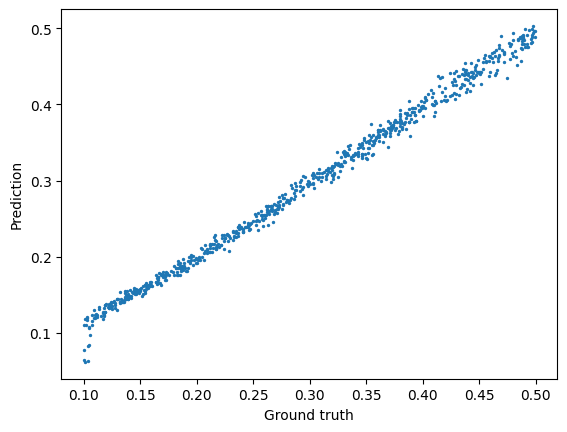

In [26]:
plt.scatter(lbl_simba, yhat_simba, s=2)
plt.xlabel('Ground truth')
plt.ylabel('Prediction')

plt.show()